#**유통 판매량 예측 및 재고 최적화**
## **단계3 : 모델링 및 비즈니스 평가**

# **0.미션**

* 단계1 다양한 모델링 수행
    * LSTM, CNN 등을 이용해서 다양한 시계열 모델링 수행
    * 성능 상위 2~3개 모델 선정
* 단계2 데이터 파이프라인 구축
    * test 데이터(raw data)로 부터 예측에 사용할 수 있는 형태로 데이터를 만드는 과정을 하나의 함수로 엮기
* 단계3 비즈니스 평가
    * 단계1에서 선정된 모델에 대해 test셋으로 평균 재고액 평가 수행

* 대상 상품(핵심 상품)

| Product_ID|Product_Code|SubCategory|Category|LeadTime|Price|
|----|----|----|----|----|----|
|3|DB001|Beverage|Drink|2|8|
|12|GA001|Milk|Food|3|6|
|42|FM001|Agricultural products|Grocery|3|5|


# **1.환경설정**

* 세부 요구사항
    * 구글콜랩
        * 구글 드라이브 바로 밑에 project 폴더를 만들고,
        * 데이터 파일을 복사해 넣습니다.
    - 라이브러리 로딩
        * 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
        * 필요하다고 판단되는 라이브러리를 추가하세요.


### **(1) 경로 설정**

* 구글 드라이브 연결

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = '/content/drive/MyDrive/project5/'

### **(2) 라이브러리 설치 및 불러오기**

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split
from tensorflow.keras.initializers import HeNormal

from sklearn.metrics import *
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
import statsmodels.api as sm
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import lightgbm as lgb

from keras.models import Sequential
from keras.backend import clear_session
from keras.layers import Dense, LSTM, Conv1D, Flatten, LSTM, Dense, Dropout, Input, MaxPooling1D
from keras.optimizers import Adam

from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
# 학습곡선 함수
def dl_history_plot(history):
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [5]:
# 예측 결과 시각화
def plot_model_result(y_train, y_val, pred) :

    y_train = pd.Series(y_train)
    y_val = pd.Series(y_val)
    y_val.index = range(len(y_train), len(y_train) + len(y_val))

    pred = pd.Series(pred.reshape(-1,), index = y_val.index)

    # 전체 시각화
    plt.figure(figsize = (20,12))
    plt.subplot(2,1,1)
    plt.plot(y_train, label = 'train')
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.subplot(2,1,2)
    plt.plot(y_val, label = 'val')
    plt.plot(pred, label = 'pred')
    plt.legend()
    plt.grid()

    plt.show()

### **(3) 데이터 불러오기**

* **세부 요구사항**
    - 상품별로 저장한 데이터를 불러오시오.

In [6]:
Beverage_data = joblib.load(f"{path}Beverage_data.pkl")

Beverage_data.head()

,Date,Qty,Weekday,Month,Season,CustomerCount,WTI_Price,City_Visitor_Count,Category_Sales_Sum,Qty_MA_7,CustomerCount_MA_7,target
1456,2014-01-02,9853.0,3,1,3,4422.0,95.14,718152.0,176120.0,1414.857143,1971.428571,15153.0
2267,2014-01-03,8647.0,4,1,3,4167.0,93.66,664872.0,151502.0,1544.824429,4385.571429,15606.0
4700,2014-01-06,7900.0,0,1,3,3917.0,93.12,614642.0,136433.0,1466.173857,4950.714286,8800.0
5511,2014-01-07,7188.0,1,1,3,3663.0,93.31,594453.0,118760.0,1226.645710,3880.714286,6606.0
6322,2014-01-08,8800.0,2,1,3,4254.0,91.90,634209.0,129368.0,1477.083857,3747.428571,7051.0


In [7]:
Agricultural_products_data = joblib.load(f"{path}Agricultural_products_data.pkl")

Agricultural_products_data.head()

,Date,Qty,Weekday,Month,Season,CustomerCount,WTI_Price,City_Visitor_Count,Category_Sales_Sum,Qty_MA_7,CustomerCount_MA_7,target
1469,2014-01-02,76.0,3,1,3,4422.0,95.14,718152.0,35336.643958,211.092000,4422.0,78.0
2280,2014-01-03,74.0,4,1,3,4167.0,93.66,664872.0,32032.468719,265.986871,4167.0,88.0
4713,2014-01-06,65.0,0,1,3,3917.0,93.12,614642.0,18564.406008,128.875567,3917.0,73.0
5524,2014-01-07,78.0,1,1,3,3663.0,93.31,594453.0,20472.028034,145.358000,3663.0,78.0
6335,2014-01-08,73.0,2,1,3,4254.0,91.90,634209.0,23568.186024,170.061714,4254.0,96.0


In [8]:
Milk_data = joblib.load(f"{path}Milk_data.pkl")

Milk_data.head()

,Date,Qty,Weekday,Month,Season,CustomerCount,WTI_Price,City_Visitor_Count,Category_Sales_Sum,Qty_MA_7,CustomerCount_MA_7,target
1462,2014-01-02,9647.0,3,1,3,4422.0,95.14,718152.0,298620.320011,4050.771571,4422.0,14188.0
2273,2014-01-03,8879.0,4,1,3,4167.0,93.66,664872.0,250953.870948,3685.427429,4167.0,14490.0
4706,2014-01-06,7614.0,0,1,3,3917.0,93.12,614642.0,233749.026011,3198.731857,3917.0,8683.0
5517,2014-01-07,7124.0,1,1,3,3663.0,93.31,594453.0,212968.889995,2959.335000,3663.0,6731.0
6328,2014-01-08,8683.0,2,1,3,4254.0,91.90,634209.0,223884.377124,3651.636857,4254.0,6992.0


# **2.모델링**

* **세부 요구사항**
    * 3차원 데이터 구조 만들기
        * timestep 수는 적절한 간격으로 한가지 경우만 지정을 합니다.
    * LSTM, CNN 기반 초기 모델 생성
        * 성능 보다는 코드 틀을 작성하는데 집중합시다.
        * 노드 혹은 필터 수와 크기는 초기값으로 적절하게 지정해 봅시다.
    * 데이터 파이프라인 함수 작성하기
        * input : raw data
        * output : x_train, x_val, y_train, y_val
        * 원본 데이터에서 일부를 떼어 놓고, 파이프라인 함수를 테스트 해 봅시다.

In [9]:
def temporalize(x, y, timesteps):
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

In [10]:
def data_pre_lstm(data, timesteps=10, y_scale=True):
    """
    데이터 전처리 함수 (LSTM용):
    1. Weekday, Month, Season 원핫 인코딩
    2. 나머지 수치형 컬럼 스케일링
    3. 데이터를 시계열 형식으로 변환
    4. 학습용, 검증용 데이터로 분할

    Parameters:
        - data: 데이터프레임
        - timesteps: 시계열 데이터를 생성할 timestep 수
        - y_scale: y 스케일링 여부

    Returns:
        - x_train: 학습용 데이터의 입력값 (시계열 형식)
        - x_val: 검증용 데이터의 입력값 (시계열 형식)
        - y_train: 학습용 데이터의 타겟 값
        - y_val: 검증용 데이터의 타겟 값
        - scaler: 같은 스케일링을 적용하거나 역변환에 사용
        - y_min: 타겟 변수 최소값
        - y_max: 타겟 변수 최대값
    """

    target = 'target'
    x = data.drop(['Date', target], axis=1)
    y = data.loc[:, target]

    # 원핫 인코딩
    categorical_features = ['Weekday', 'Month', 'Season']
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    encoded_categorical = encoder.fit_transform(x[categorical_features])
    encoded_columns = encoder.get_feature_names_out(categorical_features)

    # 원핫 인코딩 결과 데이터프레임
    encoded_df = pd.DataFrame(encoded_categorical, columns=encoded_columns, index=x.index)

    # 원핫 인코딩 적용 후 나머지 수치형 데이터 병합
    numeric_features = x.drop(categorical_features, axis=1)
    x_processed = pd.concat([numeric_features, encoded_df], axis=1)

    # 스케일링
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x_processed)

    # y 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y_scaled = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan
        y_scaled = y

    # 시계열 데이터 변환
    x_scaled = pd.DataFrame(x_scaled, index=x.index)
    x_seq, y_seq = temporalize(x_scaled, pd.Series(y_scaled), timesteps)

    # 데이터 분할
    x_train, x_val, y_train, y_val = train_test_split(x_seq, y_seq, test_size=120, shuffle=False)

    return x_train, x_val, y_train, y_val, scaler, y_min, y_max

## **(1) LSTM 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

In [11]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Beverage_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 25413.0, (667, 7, 25), (120, 7, 25))

* **모델링**

In [12]:
clear_session()

_, timesteps, nfeat = x_train.shape

model03_beverage = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, nfeat)),
    Dropout(0.3),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.3),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.3),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model03_beverage.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 32)                  │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 141,217 (551.63 KB)

 Trainable params: 141,217 (551.63 KB)

 Non-trainable params: 0 (0.00 B)

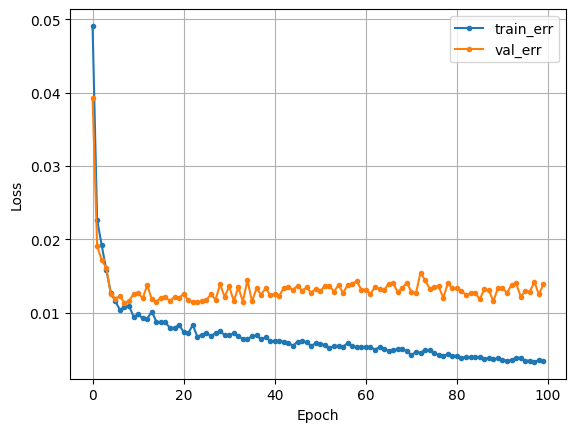

In [13]:
model03_beverage.compile(optimizer = 'adam', loss = 'mse')
hist = model03_beverage.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [14]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model03_beverage.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
MAE :  1945.8023559570313
MAPE :  4.053222805455154e+17
R2 :  0.5266960171706401


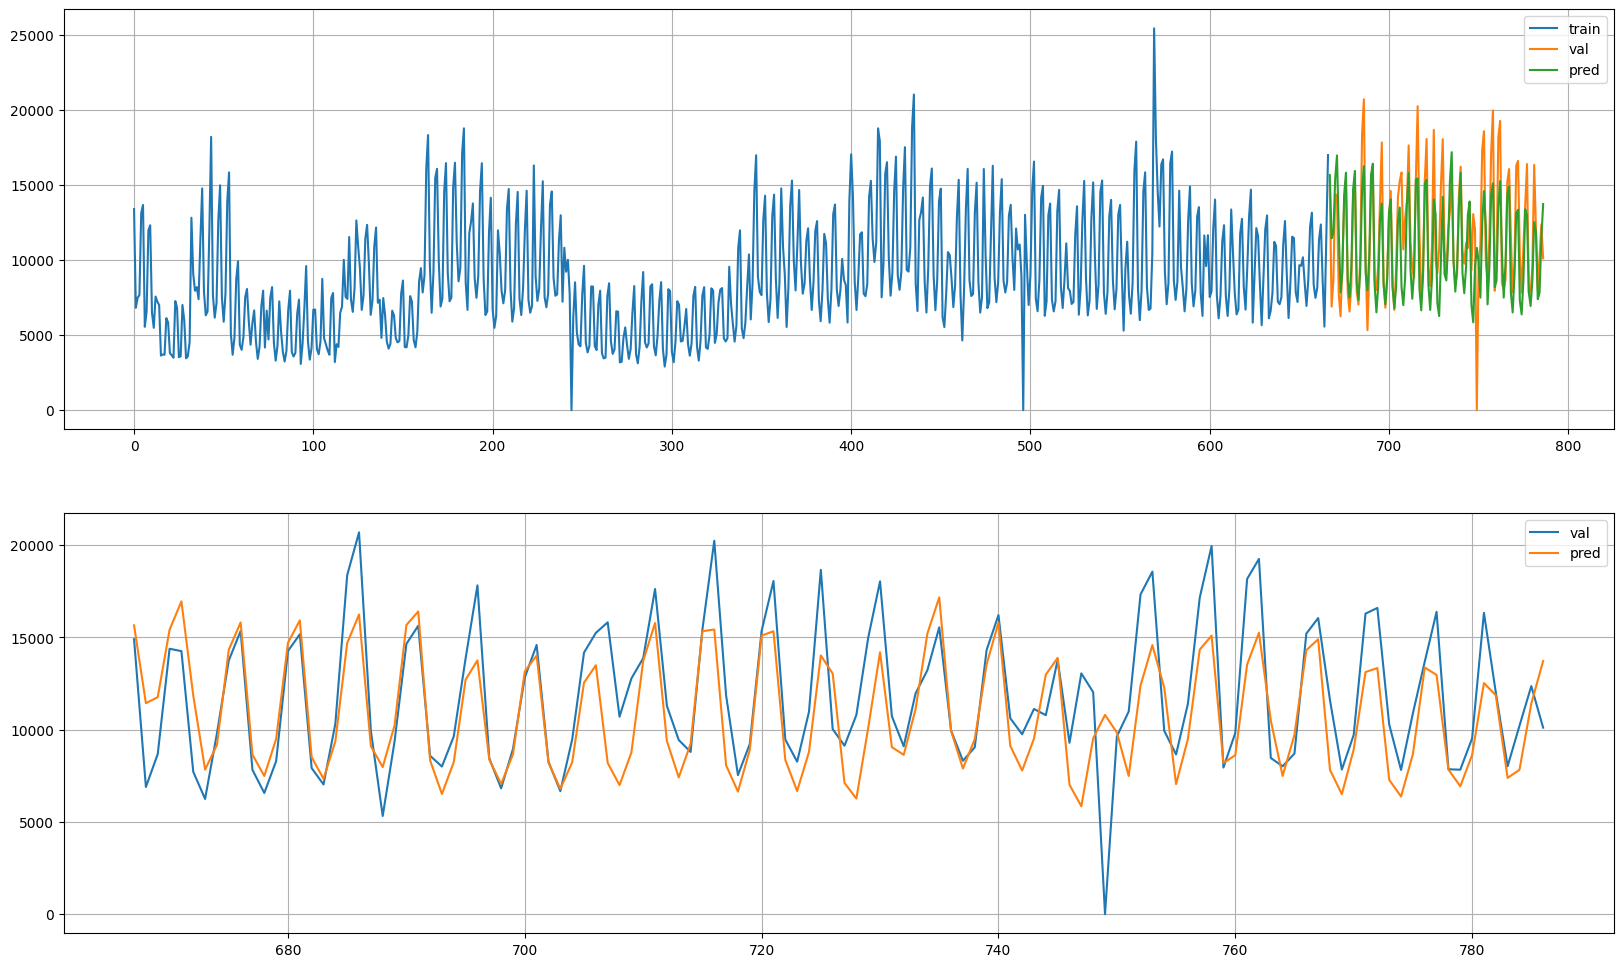

In [15]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **2) 상품 : 12 - Milk**

* **데이터 준비**

In [16]:
y_min

0.0

In [17]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Milk_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(0.0, 29670.0, (667, 7, 25), (120, 7, 25))

* **모델링**

In [18]:
clear_session()

_, timesteps, nfeat = x_train.shape

model12_Milk = Sequential([
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, nfeat)),
    Dropout(0.5),
    LSTM(128, activation='tanh', return_sequences=True, input_shape=(timesteps, nfeat)),
    Dropout(0.5),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.5),
    LSTM(64, activation='tanh', return_sequences=True),
    Dropout(0.5),
    LSTM(32, activation='tanh', return_sequences=True),
    Dropout(0.5),
    LSTM(32, activation='tanh', return_sequences=False),
    Dropout(0.5),
    Dense(16, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='linear')
])

model12_Milk.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 7, 128)              │         131,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 7, 64)               │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 7, 64)               │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 7, 64)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 7, 32)               │          12,416 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_5 (LSTM)                        │ (None, 32)                  │           8,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │             528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 314,145 (1.20 MB)

 Trainable params: 314,145 (1.20 MB)

 Non-trainable params: 0 (0.00 B)

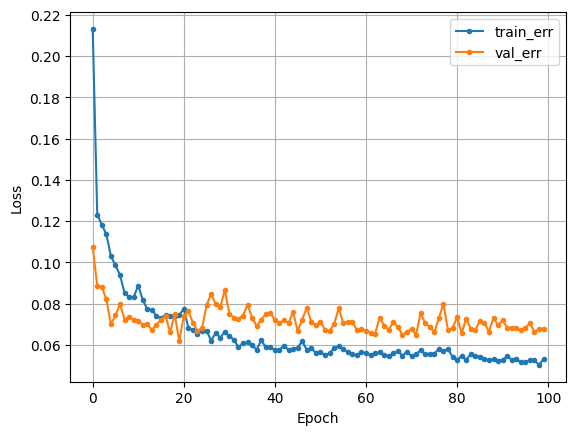

In [19]:
model12_Milk.compile(optimizer = 'adam', loss = 'mae')
hist = model12_Milk.fit(x_train, y_train, epochs = 100, validation_split = .2, verbose = 0).history
dl_history_plot(hist)

In [20]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model12_Milk.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step
MAE :  2844.151192220052
MAPE :  2.988679129229252e+17
R2 :  0.13334031599687302


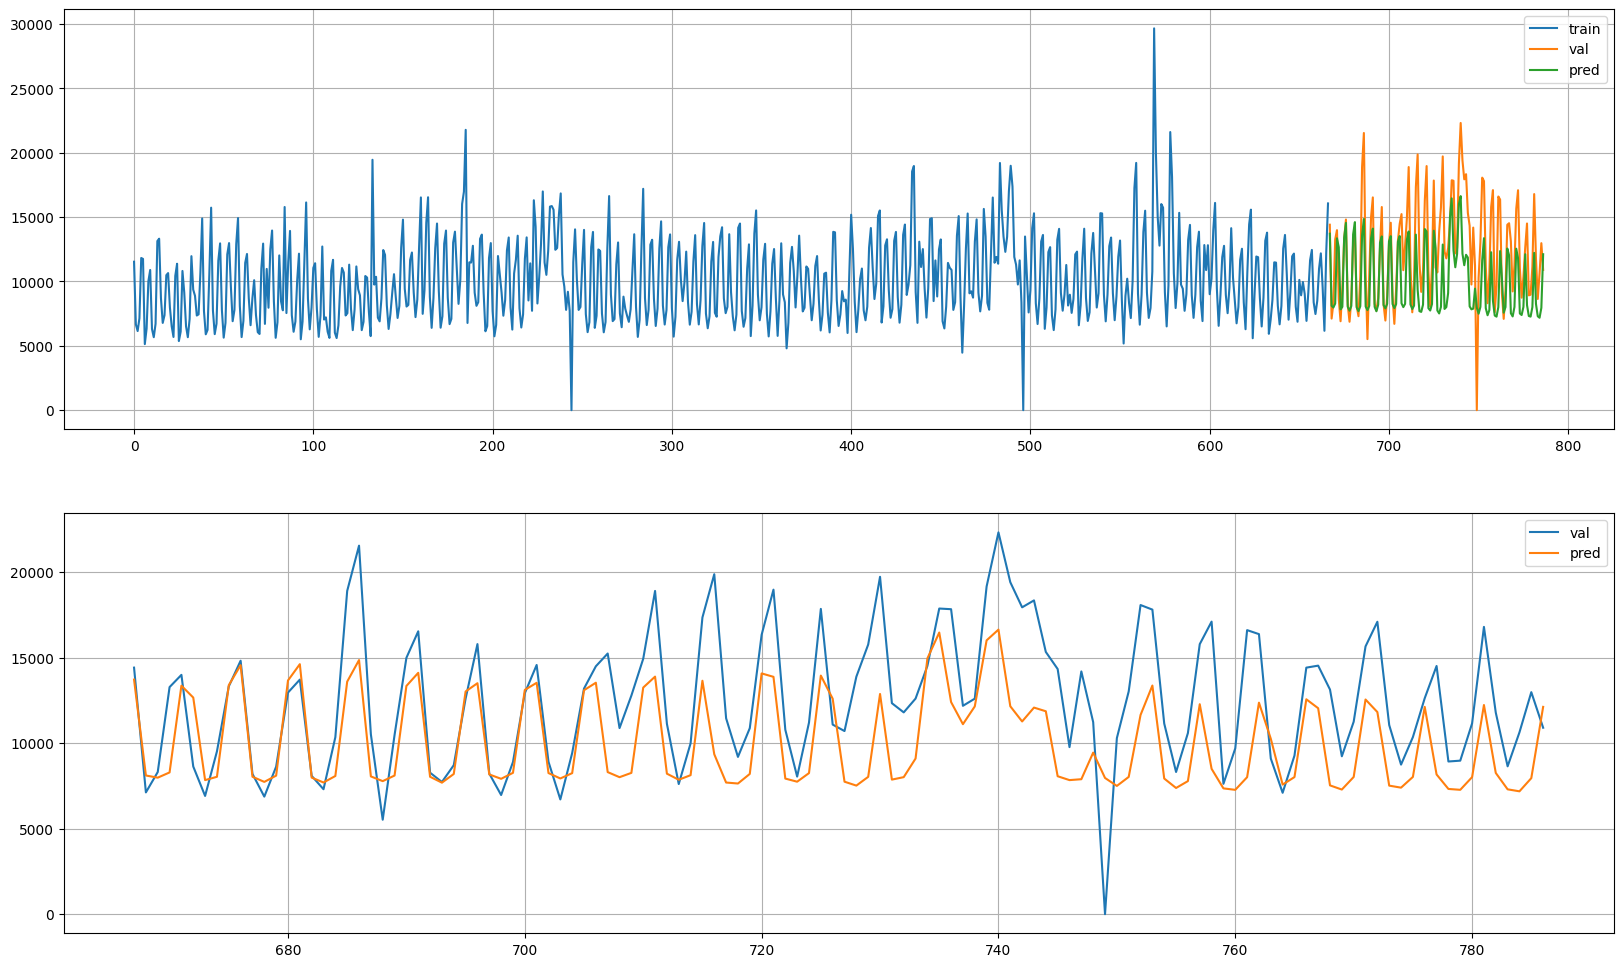

In [21]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

In [22]:
timesteps = 7
x_train, x_val, y_train, y_val, scaler, y_min, y_max = data_pre_lstm(Agricultural_products_data, timesteps, True)
y_min, y_max, x_train.shape, x_val.shape

(53.0, 196.0, (667, 7, 25), (120, 7, 25))

* **모델링**

In [38]:
clear_session()

_, timesteps, nfeat = x_train.shape

model42_Agricultural_products = Sequential([
    Input(shape=(timesteps, nfeat)),
    LSTM(128, activation='tanh', return_sequences=True),
    Dropout(0.4),
    LSTM(64, activation='tanh', return_sequences=False),
    Dropout(0.4),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])

model42_Agricultural_products.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 7, 128)              │          78,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 7, 128)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 16)                  │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              17 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 129,313 (505.13 KB)

 Trainable params: 129,313 (505.13 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1831 - val_loss: 0.0302
Epoch 2/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0241 - val_loss: 0.0192
Epoch 3/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - val_loss: 0.0255
Epoch 4/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0167 - val_loss: 0.0204
Epoch 5/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0155 - val_loss: 0.0186
Epoch 6/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0156 - val_loss: 0.0197
Epoch 7/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0144 - val_loss: 0.0254
Epoch 8/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0151 - val_loss: 0.0206
Epoch 9/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0138 - val_loss: 0.0195
Epoch 10/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0132 - val_loss: 0.0157
Epoch 11/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0124 - val_loss: 0.0198
Epoch 12/50
17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.01

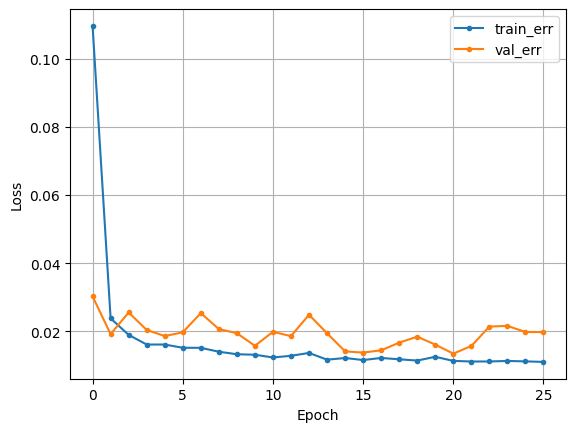

In [39]:
model42_Agricultural_products.compile(optimizer='adam', loss='mse')

# EarlyStopping 콜백 정의
early_stopping = EarlyStopping(
    monitor='val_loss',  # 검증 손실을 기준으로 모니터링
    patience=5,          # 성능 향상이 없으면 5 epoch 후 중단
    restore_best_weights=True  # 가장 좋은 가중치를 복원
)

# 모델 훈련
hist = model42_Agricultural_products.fit(
    x_train,
    y_train,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    callbacks=[early_stopping]  # EarlyStopping 추가
).history

# 학습 곡선 시각화
dl_history_plot(hist)

# optimizer = Adam(learning_rate=0.0001)
# model42_Agricultural_products.compile(optimizer = 'adam', loss = 'mae')
# hist = model42_Agricultural_products.fit(x_train, y_train, epochs = 50, validation_split = .2, verbose = 0).history
# dl_history_plot(hist)

In [40]:
# 스케일링 된 데이터 돌려서 평가하기
pred = model42_Agricultural_products.predict(x_val)
pred = pred * (y_max - y_min) + y_min
y_val2 = y_val * (y_max - y_min) + y_min

print('MAE : ', mean_absolute_error(y_val2, pred))
print('MAPE : ',mean_absolute_percentage_error(y_val2, pred))
print('R2 : ',r2_score(y_val2, pred))

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
MAE :  11.963000551859539
MAPE :  0.10744900955819486
R2 :  0.6533355950936646


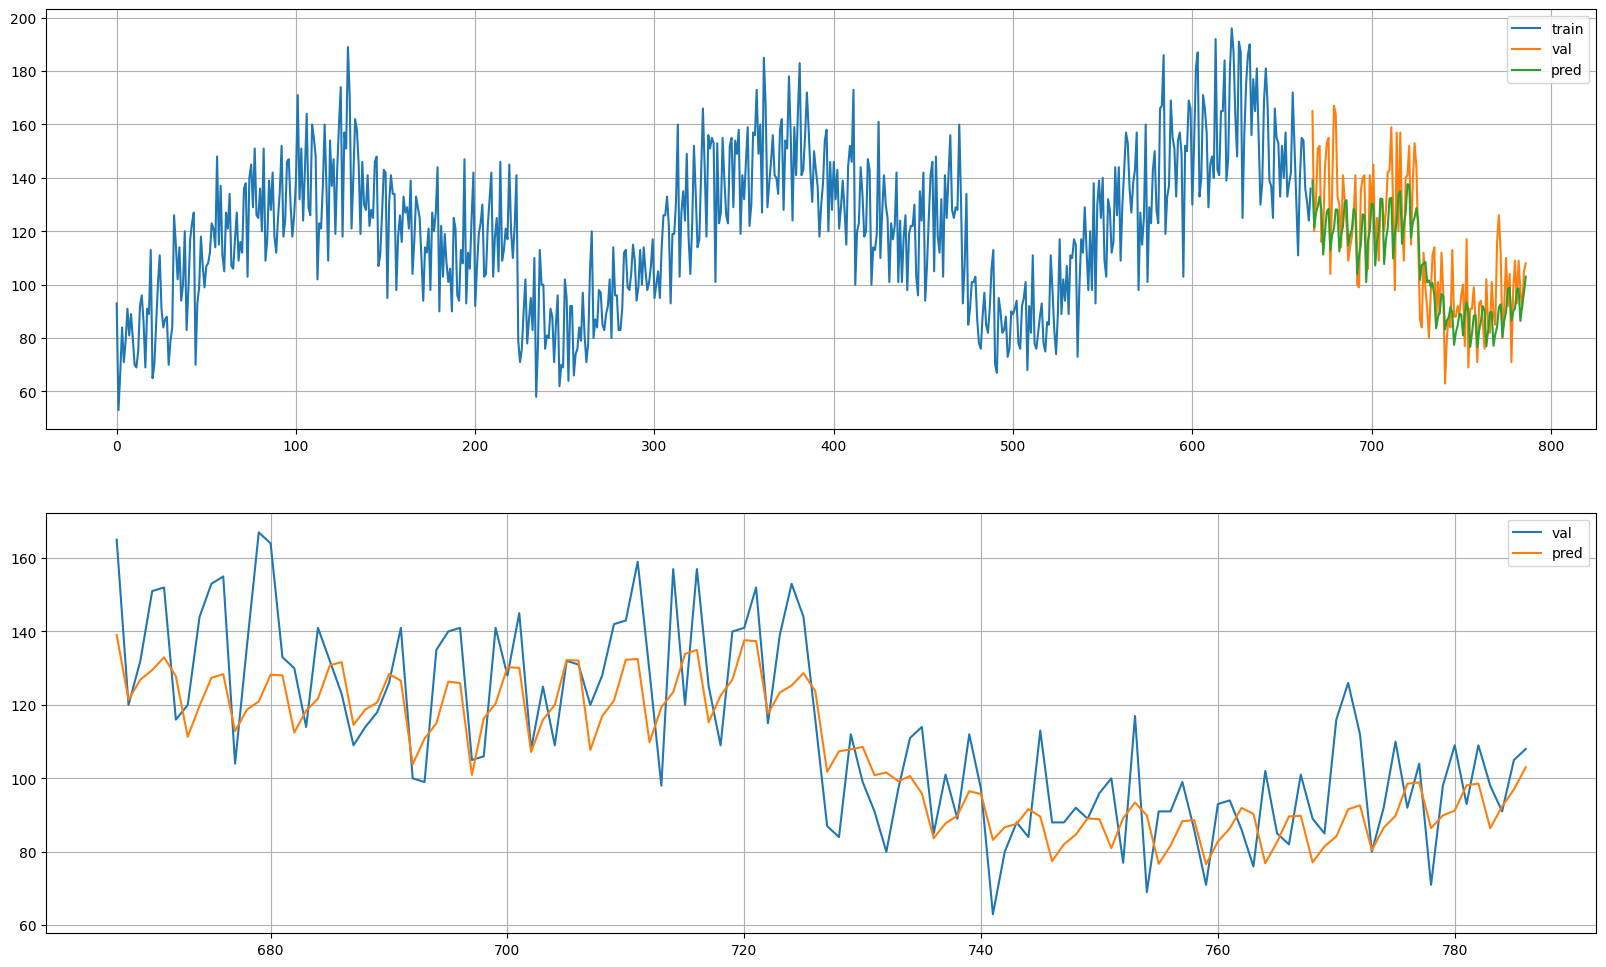

In [26]:
y_train2 = y_train * (y_max - y_min) + y_min
plot_model_result(y_train2, y_val2, pred)

## **(2) CNN 모델링**

### **1) 상품 : 3 - Beverage**

* **데이터 준비**

* **모델링**

### **2) 상품 : 12 - Milk**

* **데이터 준비**

* **모델링**

### **3) 상품 : 42 - Agricultural products**

* **데이터 준비**

* **모델링**

# **3.데이터 파이프라인 생성**

* 세부 요구사항
    * 데이터 파이프라인 함수 작성하기
        * input : raw data(sales_test, orders_test, oil_price_test, products, stores)
        * output : x_test, y_test
        * test set으로 파이프라인 함수를 테스트 해 봅시다.

## **(1) 파이프라인 함수 생성**

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import joblib

def get_season(date):
  """
  날짜를 받아 계절 정보를 반환하는 함수.
  봄: 0, 여름: 1, 가을: 2, 겨울: 3
  """
  if date.month in [3, 4, 5]:
    return 0
  elif date.month in [6, 7, 8]:
    return 1
  elif date.month in [9, 10, 11]:
    return 2
  else:
    return 3

def preprocess_data_test(sales_test, orders_test, oil_price_test, products, stores, Store_ID=None, Product_ID=None):
    """
    주어진 테스트 데이터를 전처리하고 추가적인 피처를 생성합니다.
    """

    # 판매 데이터 복사
    sell = sales_test.copy()

    # 시간 관련 파생 변수 추가
    sell['Weekday'] = sell['Date'].dt.weekday  # 요일
    sell['YearMonth'] = sell['Date'].dt.to_period('M')  # 연-월
    sell['Month'] = sell['Date'].dt.month  # 월
    sell['Season'] = sell['Date'].apply(get_season)  # 계절

    # 유가 데이터 복사
    oil = oil_price_test.copy()

    # 데이터 병합
    sell_products = sell.merge(products, on='Product_ID', how='left')
    sell_orders = sell_products.merge(orders_test, on=['Date', 'Store_ID'], how='left')
    sell_oil = sell_orders.merge(oil, on='Date', how='left')
    pre_data = sell_oil.merge(stores, on='Store_ID', how='left')

    # 결측치 처리: 방문자 수
    pre_data['CustomerCount'] = pre_data.groupby(['YearMonth', 'Weekday'])['CustomerCount'].transform(
        lambda x: x.fillna(x.mean().round(0))
    )

    # 동일 지역 방문객 수
    pre_data['City_Visitor_Count'] = pre_data.groupby(['Date', 'City'])['CustomerCount'].transform('sum')

    # 동일 카테고리 판매량 합계
    pre_data['Category_Sales_Sum'] = pre_data.groupby(['Date', 'Category'])['Qty'].transform('sum')

    # 7일 판매량 이동 평균
    pre_data['Qty_MA_7'] = pre_data.groupby('Store_ID')['Qty'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

    # 7일 방문자 수 이동 평균
    pre_data['CustomerCount_MA_7'] = pre_data.groupby('Store_ID')['CustomerCount'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())

    # Target 생성: LeadTime 뒤 판매량을 타겟으로 설정
    pre_data['target'] = pre_data.groupby(['Store_ID', 'Product_ID']).apply(
        lambda group: group['Qty'].shift(-group['LeadTime'].iloc[0]) if group['LeadTime'].notna().all() else None
    ).reset_index(level=[0, 1], drop=True)

    # 결측치 제거
    pre_data.dropna(inplace=True)

    # 특정 매장 및 상품 필터링
    if Store_ID is not None:
        pre_data = pre_data[pre_data['Store_ID'] == Store_ID]
    if Product_ID is not None:
        pre_data = pre_data[pre_data['Product_ID'] == Product_ID]

    # 불필요한 열 삭제
    columns_to_drop = ['Product_Code', 'Store_ID', 'Product_ID', 'SubCategory', 'City', 'State', 'Store_Type', 'Category', 'YearMonth', 'LeadTime', 'Price']
    pre_data = pre_data.drop(columns=columns_to_drop, errors='ignore')

    return pre_data

def temporalize(x, y, timesteps):
    """데이터를 시계열 형식으로 변환하는 함수."""
    output_X = []
    output_y = []
    for i in range(len(x) - timesteps + 1):
        output_X.append(x.iloc[i:i+timesteps])
        output_y.append(y.iloc[i+timesteps-1])
    return np.array(output_X), np.array(output_y)

def data_pre_lstm(data, timesteps=10, y_scale=True):
    """LSTM용 데이터 전처리 함수."""
    target = 'target'
    x = data.drop(['Date', target], axis=1)
    y = data.loc[:, target]

    # 스케일링
    scaler = MinMaxScaler()
    x_scaled = scaler.fit_transform(x)

    # y 스케일링
    if y_scale:
        y_min, y_max = y.min(), y.max()
        y_scaled = (y - y_min) / (y_max - y_min)
    else:
        y_min, y_max = np.nan, np.nan
        y_scaled = y

    # 시계열 데이터 변환
    x_scaled = pd.DataFrame(x_scaled, index=x.index)
    x_seq, y_seq = temporalize(x_scaled, pd.Series(y_scaled), timesteps)

    return x_seq, y_seq, scaler, y_min, y_max

def data_pipeline_with_prediction(
    sales_test, orders_test, oil_price_test, products, stores,
    Store_ID=None, Product_ID=None, timesteps=10
):
    """
    데이터 파이프라인 함수 (테스트 데이터 예측 포함):
    - 입력 데이터를 전처리하고, Product_ID에 따라 모델을 불러와 예측값 생성.

    Returns:
        - result_df: 예측 결과 데이터프레임
    """
    # 전처리 함수 호출
    pre_data = preprocess_data_test(sales_test, orders_test, oil_price_test, products, stores, Store_ID, Product_ID)

    # LSTM용 데이터 전처리
    x_test, y_test, scaler, y_min, y_max = data_pre_lstm(pre_data, timesteps, y_scale=True)

    # Product_ID에 따라 모델 로드
    if Product_ID == 42:
        model = model42_Agricultural_products
    elif Product_ID == 12:
        model = model12_Milk
    elif Product_ID == 3:
        model = model03_beverage
    else:
        raise ValueError(f"err!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!")

    # 예측값 생성
    pred_scaled = model.predict(x_test)
    pred = pred_scaled * (y_max - y_min) + y_min
    y_test_actual = y_test * (y_max - y_min) + y_min

    # 결과 데이터프레임 생성
    result_df = pd.DataFrame({
        'Predicted': pred.flatten(),
        'Actual': y_test_actual.flatten()
    })

    return result_df


In [32]:
y_pred = result_df['Predicted']
y_actual = result_df['Actual']

# R2 스코어 계산 및 출력
print('R2 : ', r2_score(y_actual, y_pred))

R2 :  -0.4363319509125023


## **(2) test 데이터로 확인**

* test용 데이터셋들 로딩

In [28]:
oil_price_test = pd.read_csv(path + 'test/oil_price_test.csv')
orders_test = pd.read_csv(path + 'test/orders_test.csv')
sales_test = pd.read_csv(path + 'test/sales_test.csv')
products = pd.read_csv(path + 'test/products.csv')
stores = pd.read_csv(path + 'test/stores.csv')

sales_test['Date'] = pd.to_datetime(sales_test['Date'] )
oil_price_test['Date'] = pd.to_datetime(oil_price_test['Date'] )
orders_test['Date'] = pd.to_datetime(orders_test['Date'] )

* 예측해보기

In [41]:
result_df = data_pipeline_with_prediction(
    sales_test, orders_test, oil_price_test, products, stores,
    Store_ID=44, Product_ID=42, timesteps=7
)

print(result_df)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 262ms/step
     Predicted  Actual
0   102.698036   131.0
1   102.427666   145.0
2   101.989410   107.0
3   102.142288   108.0
4   102.081123   136.0
5   102.075256   119.0
6   101.867348   138.0
7   101.365746   108.0
8   101.474953    91.0
9   101.701088   111.0
10  101.683624   117.0
11  101.475227   132.0
12  101.128044    98.0
13  101.399940   103.0
14  101.792747   119.0


In [ ]:
result_df = data_pipeline_with_prediction(
    sales_test, orders_test, oil_price_test, products, stores,
    Store_ID=44, Product_ID=12, timesteps=7
)

# 예측값과 실제값 추출
y_pred = result_df['Predicted']
y_actual = result_df['Actual']

# R2 스코어 계산 및 출력
print('R2 : ', r2_score(y_actual, y_pred))



# **4.비즈니스 평가**

* 세부 요구사항
    * 기본 시뮬레이션 함수가 제공됩니다.
        * 필요하다면 해당 함수를 수정해서 사용할 수 있습니다.
    * 시뮬레이션 함수 사용하여 재고 평가
        * 실제값, 예측값, 안전재고 수량을 넣고 일평균 재고 금액을 확인합니다.
        * 기회손실수량은 0으로 맞추도록 안전재고 수량을 조절합니다.
        * 평균재고금액을 확인합니다.
    * 데이터는 test 셋을 이용합니다.
        * 예측 후 재고 평가 시, 스케일링된 y를 원래대로 돌려 놓아야 합니다.
            * y_real = y_sacled * (y_max - y_min) + y_min
            * pred_real = pred * (y_max - y_min) + y_min

## **(1) 재고 시뮬레이터**

In [30]:
def inv_simulator(y, pred, safe_stock, price) :

    # 시뮬레이션 df 틀 만들기
    temp = pd.DataFrame({'y':y.reshape(-1,), 'pred':pred.reshape(-1,).round()})

    temp['base_stock'] = 0
    temp['close_stock'] = 0
    temp['order'] = 0
    temp['receive'] = 0

    # 시뮬레이션

    for i in range(len(temp)-2):  # 발주량은 leadtime 후 판매 예측량에 기초하므로 계산을 위해 마지막 leadtime 만큼의 행 제외
        if i == 0 : #첫 행. 2일 전 데이터가 없으므로,
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y']  # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + safe_stock  # 기초재고는 실판매량 + 안전재고로 계산

        elif i == 1 : # 둘째 행, 2일 전 데이터가 없음.
            temp.loc[ i ,'receive'] = temp.loc[ i ,'y'] # 입고량은 실판매량으로 계산
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']
        else :      # 나머지 전체 행.
            temp.loc[ i ,'receive'] = temp.loc[ i-2 ,'order']    # 입고량 = 2일전 발주량
            temp.loc[ i ,'base_stock'] = temp.loc[ i ,'receive'] + temp.loc[ i-1 ,'close_stock']  # 기초재고 = 입고량 + 전날 기말재고

        # 기말재고 = 기초재고 - 판매량,  만약 0보다 작으면 0으로.
        stock = round(temp.loc[i, 'base_stock'] - temp.loc[i, 'y'])
        temp.loc[i, 'close_stock'] = np.where(stock> 0, stock, 0)

        # 발주량 = 2일후 판매예측량 + 안전재고 - 기말재고,  만약 주문량이 0보다 작으면 0
        order = temp.loc[i+2, 'pred'] + safe_stock - temp.loc[i, 'close_stock']
        temp.loc[i, 'order'] = np.where(order>0,order, 0)

    # 기회손실 = 만약 (기초재고 - 실판매량)이 0보다 작으면, 그만큼이 기회손실
    temp['lost'] = np.where((temp['base_stock'] - temp['y'])<0, (temp['base_stock'] - temp['y']),0).round()

    inventory = temp[:len(temp)-2]

    # 측정지표 계산
    DailyStock = ((inventory['base_stock'] + inventory['close_stock'])/2)
    DailyTurnover = (inventory['y'] + inventory['lost']) / DailyStock

    AvgDailyStock = round(DailyStock.mean(),3)
    AvgDailyStockAmt = AvgDailyStock * price
    turnover = round(DailyTurnover.mean(), 3)
    lost_sum = inventory['lost'].sum()


    print(f'일평균 재고량     : {AvgDailyStock}')
    print(f'일평균 재고 금액  : {AvgDailyStockAmt}')
    print(f'일평균 재고회전율 : {turnover}')
    print(f'기회손실 수량     : {lost_sum}')

    return inventory

## **(2) 예측 결과 시뮬레이션(재고금액 평가)**


In [31]:
products[products['Product_ID'] == 42]

,Product_ID,Product_Code,SubCategory,Category,LeadTime,Price
15,42,FM001,Agricultural products,Grocery,2,5


In [33]:
inv_simulator(result_df['Actual'].values, result_df['Predicted'].values, 30, 5)

일평균 재고량     : 82.769
일평균 재고 금액  : 413.845
일평균 재고회전율 : 1.477
기회손실 수량     : -59.0


,y,pred,base_stock,close_stock,order,receive,lost
0,131.0,107.0,161,30,107,131,0.0
1,145.0,107.0,175,30,107,145,0.0
2,107.0,107.0,137,30,108,107,0.0
3,108.0,107.0,137,29,109,107,0.0
4,136.0,108.0,137,1,137,108,0.0
5,119.0,108.0,110,0,137,109,-9.0
6,138.0,108.0,137,0,137,137,-1.0
7,108.0,107.0,137,29,108,137,0.0
8,91.0,107.0,166,75,63,137,0.0
9,111.0,107.0,183,72,65,108,0.0
